In [1]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

from torchsummary import summary
from torchscan import summary

# Let's visualize some of the images
%matplotlib inline
import matplotlib.pyplot as plt
import argparse

from torch.optim.lr_scheduler import StepLR,OneCycleLR

from train import *
from test import *
#from model import *
from plotter import *
from data import *
# from model_group_norm import *
# from model_layer_norm import *

#from parser_args import norm, epochs
from custom_resnet import *
import albumentations as A
import matplotlib.pyplot as plt
from albumentations.pytorch import ToTensorV2

In [2]:
# train dataloader
train_loader = load_train()

# test dataloader
test_loader = load_test()

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


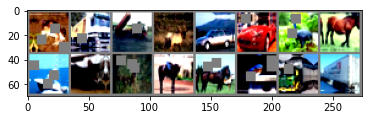

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import torchvision
# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))


# get some random training images
dataiter = iter(train_loader)
images, labels = dataiter.next()

# show images
# imshow(torchvision.utils.make_grid(images["image"]))

imshow(torchvision.utils.make_grid(images[:16]))
# print labels
# print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [4]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

CUDA Available? True


In [4]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print("Using: ",device)

Using:  cuda


In [5]:
model = CustomResNet().to(device)

In [6]:
summary(model, input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
              ReLU-3           [-1, 64, 32, 32]               0
            Conv2d-4          [-1, 128, 32, 32]          73,728
         MaxPool2d-5          [-1, 128, 16, 16]               0
       BatchNorm2d-6          [-1, 128, 16, 16]             256
              ReLU-7          [-1, 128, 16, 16]               0
            Conv2d-8          [-1, 128, 16, 16]         147,456
       BatchNorm2d-9          [-1, 128, 16, 16]             256
             ReLU-10          [-1, 128, 16, 16]               0
           Conv2d-11          [-1, 128, 16, 16]         147,456
      BatchNorm2d-12          [-1, 128, 16, 16]             256
             ReLU-13          [-1, 128, 16, 16]               0
       BasicBlock-14          [-1, 128,

In [7]:
from torchscan import summary

summary(model, (3, 32, 32), receptive_field=True, max_depth=1)

____________________________________________________________________________________________________________
Layer                        Type                  Output Shape              Param #         Receptive field
baseresnet                   BaseResNet            (-1, 10)                  0               88             
├─prep_layer                 Sequential            (-1, 64, 32, 32)          1,985           88             
├─layer1                     Sequential            (-1, 128, 16, 16)         74,241          86             
├─residual_module1           BasicBlock            (-1, 128, 16, 16)         295,938         42             
├─layer2                     Sequential            (-1, 256, 8, 8)           295,937         38             
├─layer3                     Sequential            (-1, 512, 4, 4)           1,181,697       18             
├─residual_module2           BasicBlock            (-1, 512, 4, 4)           4,722,690       8              
├─pool             

/home/cv/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/torchscan/process/memory.py:32: UserWarning: raised: __init__() got an unexpected keyword argument 'capture_output'. Assuming no GPU is available.
  warnings.warn(f"raised: {e}. Assuming no GPU is available.")


In [8]:
# optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
# criterion = nn.CrossEntropyLoss()
# lr_finder = LRFinder(net, optimizer, criterion, device=device)
# lr_finder.range_test(train_loader, end_lr=10, num_iter=200)
# lr_finder.plot()

In [9]:
# start_lr = 1e-3
# end_lr = 0.5
# lrmax= trigger_training.find_lr(model,train_loader, test_loader, start_lr, end_lr)

Stopping early, the loss has diverged

Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 1.07E+00


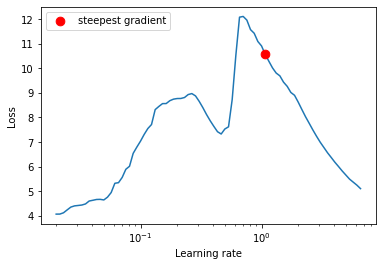

(<AxesSubplot:xlabel='Learning rate', ylabel='Loss'>, 1.0722672220103235)

In [11]:
from torch_lr_finder import LRFinder

optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
criterion = nn.CrossEntropyLoss()
lr_finder = LRFinder(model, optimizer, criterion, device="cuda")
lr_finder.range_test(train_loader, end_lr=10, num_iter=100)
lr_finder.plot() # to inspect the loss-learning rate graph
#lr_finder.reset() # to reset the model and optimizer to their initial state


In [12]:
min_loss = min(lr_finder.history['loss'])
lr_rate = lr_finder.history['lr'][np.argmin(lr_finder.history['loss'], axis=0)]
print("Max LR is {}".format(lr_rate))

Max LR is 0.01


In [15]:
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, 
                                                max_lr=lr_rate/10,
                                                steps_per_epoch=len(train_loader), 
                                                epochs=24,
                                                pct_start=0.2,
                                                div_factor=10, 
                                                final_div_factor=50,
                                                anneal_strategy='linear'
                                                )

train_losses = []
test_losses = []
train_accuracy = []
test_accuracy = []
train_acc=[]
train_loss=[]
epochs=24
for epoch in range(1, epochs + 1):
    print(f'Epoch {epoch}:')
    train_acc, train_loss = train(model, device, train_loader, optimizer, scheduler, criterion)
    train_accuracy.append(train_acc)
    train_losses.append(train_loss)

  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 1:


  0%|          | 0/98 [00:00<?, ?it/s]


RuntimeError: CUDA out of memory. Tried to allocate 128.00 MiB (GPU 0; 3.95 GiB total capacity; 2.19 GiB already allocated; 47.69 MiB free; 2.39 GiB reserved in total by PyTorch)